58 58 58 58


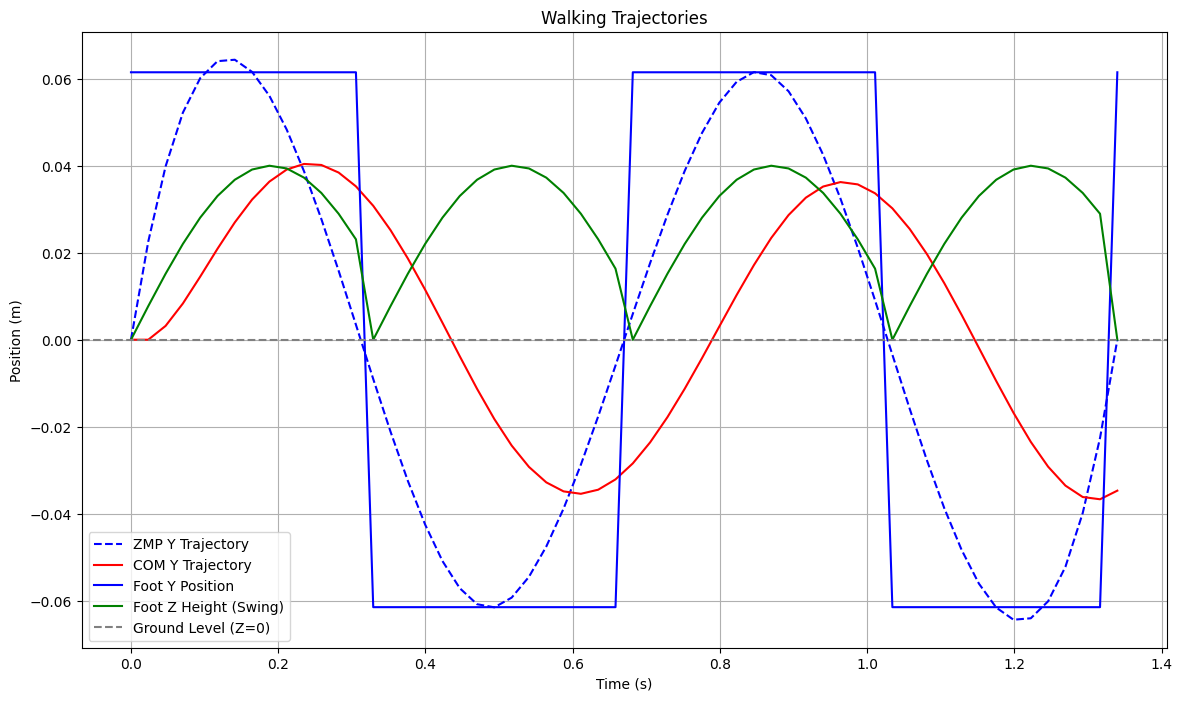

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

G = 9.81
DT = 0.005

# POSTURE
COM_HEIGHT = 0.349
FOOT_HEIGHT = 0.04

# FEET
FEET_SPACING = 0.12294
FOOT_LENGTH = 0.135
FOOT_WIDTH = 0.067

# TIMING
SSP_DURATION = 0.38
DSP_DURATION = 0.1
SSP_TIMESTEPS = 10
DSP_TIMESTEPS = int(DSP_DURATION / (SSP_DURATION / SSP_TIMESTEPS))
PLANNED_TIMESTEPS = 48

# TESTING
STEPS = 4

def generate_zmp_points():
    """Generate ZMP waypoints including double support phases."""
    zmp_points = [[0.0, 0.0]]  # Initial double support phase
    for step in range(STEPS):
        if step % 2 == 0:
            zmp_points.append([0.0, FEET_SPACING / 2])  # Left foot support
        else:
            zmp_points.append([0.0, -FEET_SPACING / 2])  # Right foot support
    zmp_points.append([0.0, 0.0])  # Final double support phase
    return np.array(zmp_points)

def interpolate_zmp(zmp_points):
    """Interpolate ZMP trajectory, including double support phases."""
    # Define total timesteps, including DSP and SSP phases
    total_timesteps = (len(zmp_points) - 1) * SSP_TIMESTEPS + (len(zmp_points) - 2) * DSP_TIMESTEPS
    time_points = [0]
    
    # Define times for each ZMP point, including DSP
    for i in range(1, len(zmp_points)):
        if i == 1 or i == len(zmp_points) - 1:  # First and last DSP
            time_points.append(time_points[-1] + DSP_DURATION)
        else:  # SSP
            time_points.append(time_points[-1] + SSP_DURATION)

    # Interpolation with periodic boundary condition
    spline_y = CubicSpline(time_points, zmp_points[:, 1], bc_type="not-a-knot")
    t_interpolated = np.linspace(0, time_points[-1], total_timesteps)
    zmp_trajectory = np.array([[0.0] * len(t_interpolated), spline_y(t_interpolated)]).T
    return t_interpolated, zmp_trajectory

def generate_com_trajectory(zmp_trajectory):
    com_trajectory = [zmp_trajectory[0].tolist()]
    for i in range(1, len(zmp_trajectory)):
        acc = (G / COM_HEIGHT) * (np.array(zmp_trajectory[i - 1]) - np.array(com_trajectory[i - 1]))
        com_trajectory.append((np.array(com_trajectory[i - 1]) + acc * DT).tolist())
    return np.array(com_trajectory)

def generate_foot_trajectory(t_interp, zmp_trajectory):
    """Generate synchronized foot trajectory based on ZMP transitions."""
    foot_trajectory = []
    current_support = "left"  # Start with left foot support
    initial_swing = True
    swing_trajectory = np.zeros_like(t_interp)  # Default Z-height for swing foot
    foot_y_positions = []

    for i, t in enumerate(t_interp):
        # Check ZMP position to determine support foot
        zmp_y = zmp_trajectory[i, 1]
        if zmp_y > 0:  # Left foot support
            active_support = "left"
        elif zmp_y < 0:  # Right foot support
            active_support = "right"
        else:
            active_support = current_support  # DSP, retain previous support

        # Switch swing trajectory if support changes
        if active_support != current_support or initial_swing:
            swing_trajectory[i:] = FOOT_HEIGHT * np.sin(
              np.pi * (t_interp[i:] - t_interp[i]) / SSP_DURATION
            )  # Simple sine motion for swing
            current_support = active_support
            initial_swing = False

        # Record foot Y position based on active support
        if current_support == "left":
            foot_y_positions.append([0, FEET_SPACING / 2, swing_trajectory[i]])
        else:
            foot_y_positions.append([0, -FEET_SPACING / 2, swing_trajectory[i]])

    return np.array(foot_y_positions)


def visualize_trajectories(t_interp, zmp_trajectory, com_trajectory, foot_trajectory):
    plt.figure(figsize=(14, 8))

    # ZMP Trajectory
    plt.plot(t_interp, zmp_trajectory[:, 1], label="ZMP Y Trajectory", color="blue", linestyle="--")

    # COM Trajectory
    plt.plot(t_interp, com_trajectory[:, 1], label="COM Y Trajectory", color="red")

    # Foot Trajectory
    plt.plot(t_interp, foot_trajectory[:, 1], label="Foot Y Position", color="blue")
    plt.plot(t_interp, foot_trajectory[:, 2], label="Foot Z Height (Swing)", color="green")
    plt.axhline(y=0, color="gray", linestyle="--", label="Ground Level (Z=0)")

    # Support Polygon (gray rectangles)
    # for i in range(len(zmp_trajectory[::SSP_TIMESTEPS + DSP_TIMESTEPS])):
    #     if i >= len(foot_trajectory):
    #         break
    #     zmp = zmp_trajectory[i * (SSP_TIMESTEPS + DSP_TIMESTEPS)]
    #     x, y = zmp[0], zmp[1]
    #     plt.gca().add_patch(plt.Rectangle(
    #         (x - FOOT_LENGTH / 2, y - FOOT_WIDTH / 2),
    #         FOOT_LENGTH,
    #         FOOT_WIDTH,
    #         edgecolor='gray',
    #         facecolor='gray',
    #         alpha=0.3
    #     ))

    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Walking Trajectories")
    plt.legend()
    plt.grid()
    plt.show()

zmp_waypoints = generate_zmp_points()
t_interp, zmp_trajectory = interpolate_zmp(zmp_waypoints)
com_trajectory = generate_com_trajectory(zmp_trajectory)
foot_trajectory = generate_foot_trajectory(t_interp, zmp_trajectory)

# Ensure lengths are consistent
print(len(t_interp), len(zmp_trajectory), len(com_trajectory), len(foot_trajectory))

# Visualization
visualize_trajectories(t_interp, zmp_trajectory, com_trajectory, foot_trajectory)
